<a href="https://colab.research.google.com/github/fiftybucks101/Logistic_Regression/blob/main/Experimental_Heart_Failure_Handling_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [193]:
df = pd.read_csv('/content/heart_failure_clinical_records.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


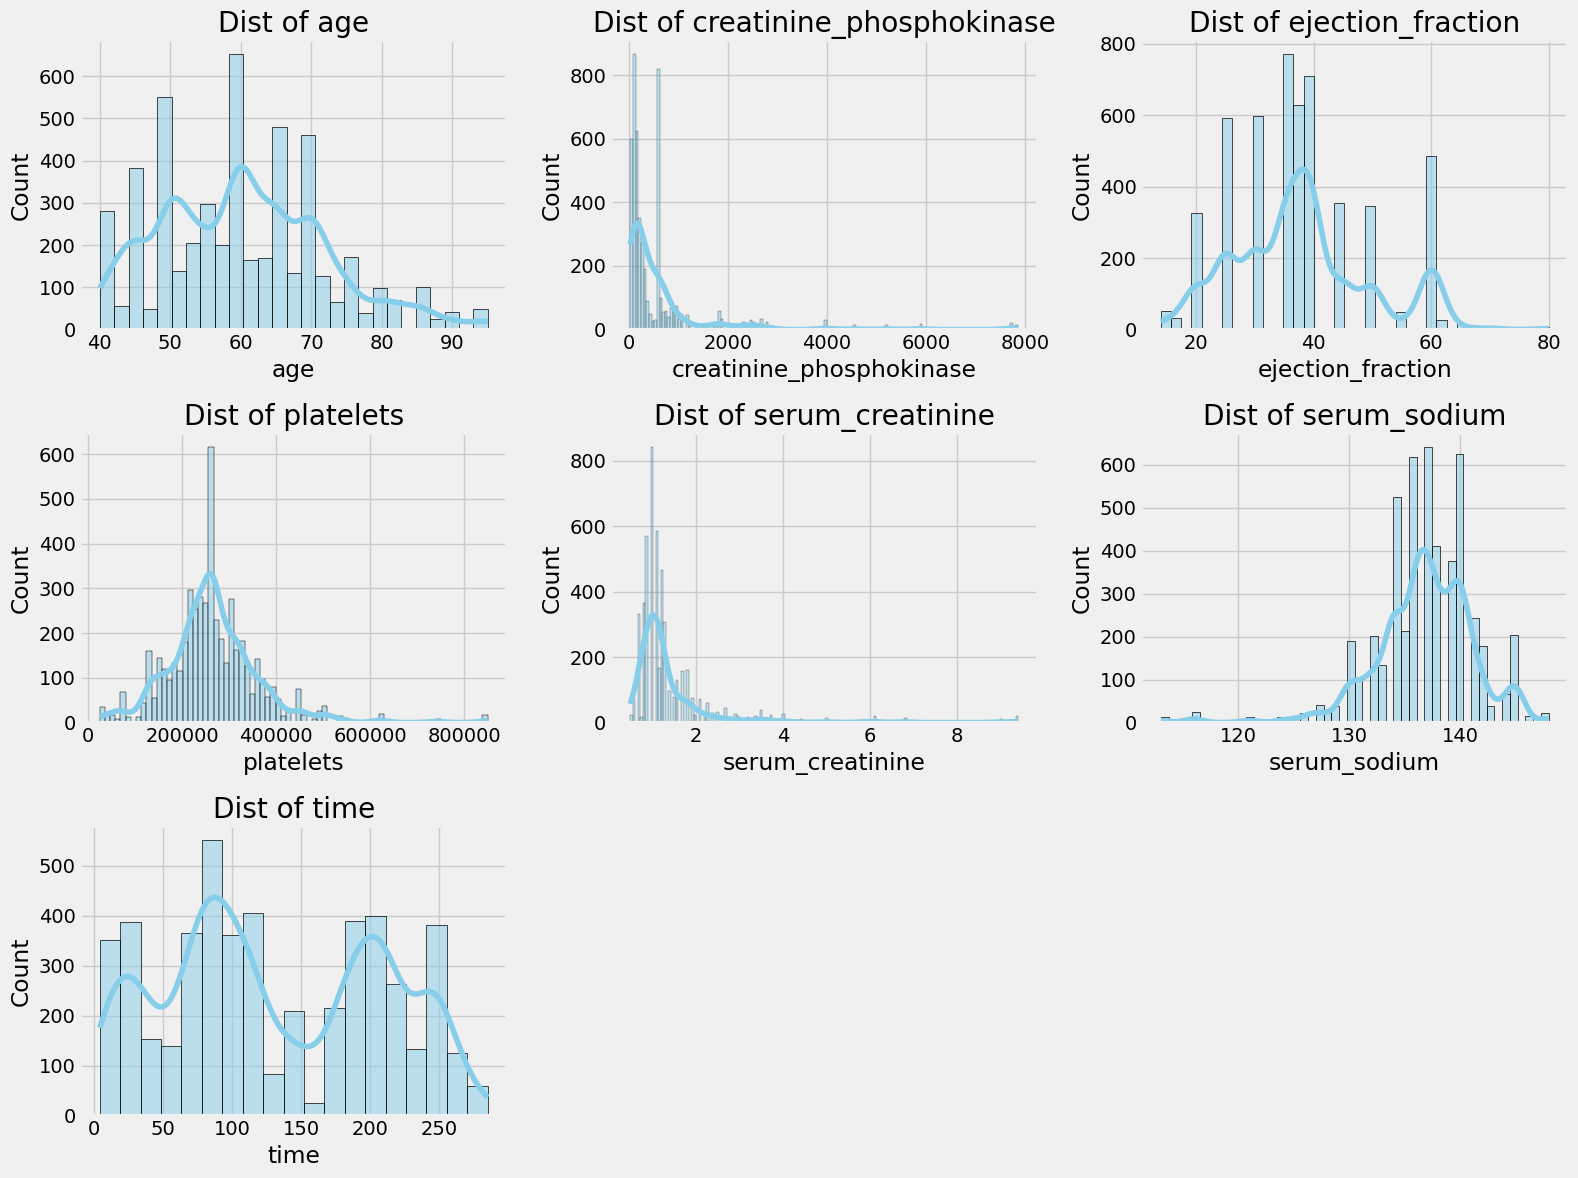

In [194]:
# let's observe distributions of numerical features

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(3,3,figsize=(16,12))

# converts multidimension array into single dimension
axs = np.ravel(axs)

for index, value in enumerate(numerical_features):
  sns.histplot(data=df,x=value,ax=axs[index],kde=True,color = 'skyblue',edgecolor = 'black')
  axs[index].set_title(f'Dist of {value}')

axs[7].set_visible(False)  # Hide subplot 8
axs[8].set_visible(False)  # Hide subplot 9
plt.tight_layout()
plt.show()

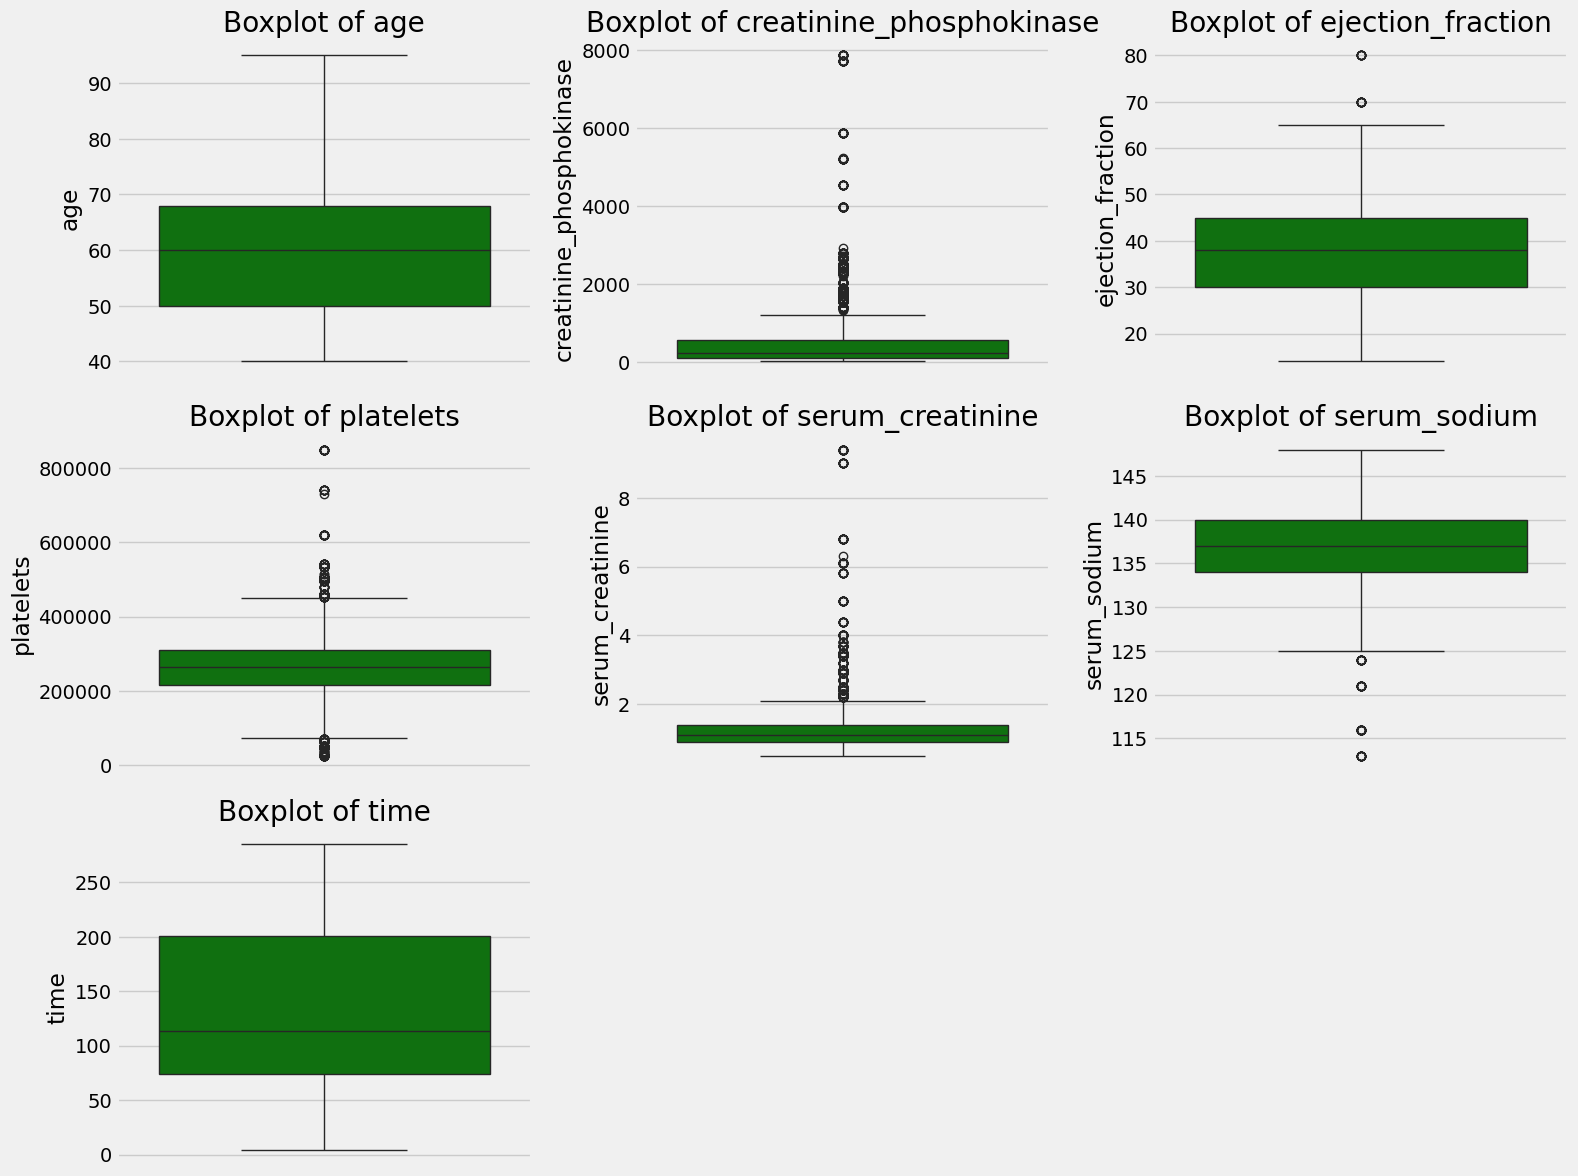

In [195]:
# Outliers in numerical columns

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(3,3,figsize=(16,12))

# converts multidimension array into single dimension
axs = np.ravel(axs)

for index, value in enumerate(numerical_features):
  sns.boxplot(data=df,y=value,ax=axs[index],color='green')
  axs[index].set_title(f'Boxplot of {value}')

axs[7].set_visible(False)  # Hide subplot 8
axs[8].set_visible(False)  # Hide subplot 9
plt.tight_layout()
plt.show()

In [196]:
# transformation on creatinine_phosphokinase & serum_creatinine, since they both are highly right skewed

# First applying log normal transformation

# df['creatinine_phosphokinase'] = np.log(df['creatinine_phosphokinase'])
# df['serum_creatinine'] = np.log(df['serum_creatinine'] )

In [197]:
# fig, axs = plt.subplots(1,2,figsize=(12,6))
# sns.histplot(data=df,x='creatinine_phosphokinase',kde=True,ax=axs[0],bins=20)
# axs[0].set_title('Log Normal Distribution of Creatinine Phosphokinase')

# sns.histplot(data=df,x='serum_creatinine',kde=True,ax=axs[1],bins=20)
# axs[1].set_title('Log Normal Distribution of Serum Creatinine')

In [198]:
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer

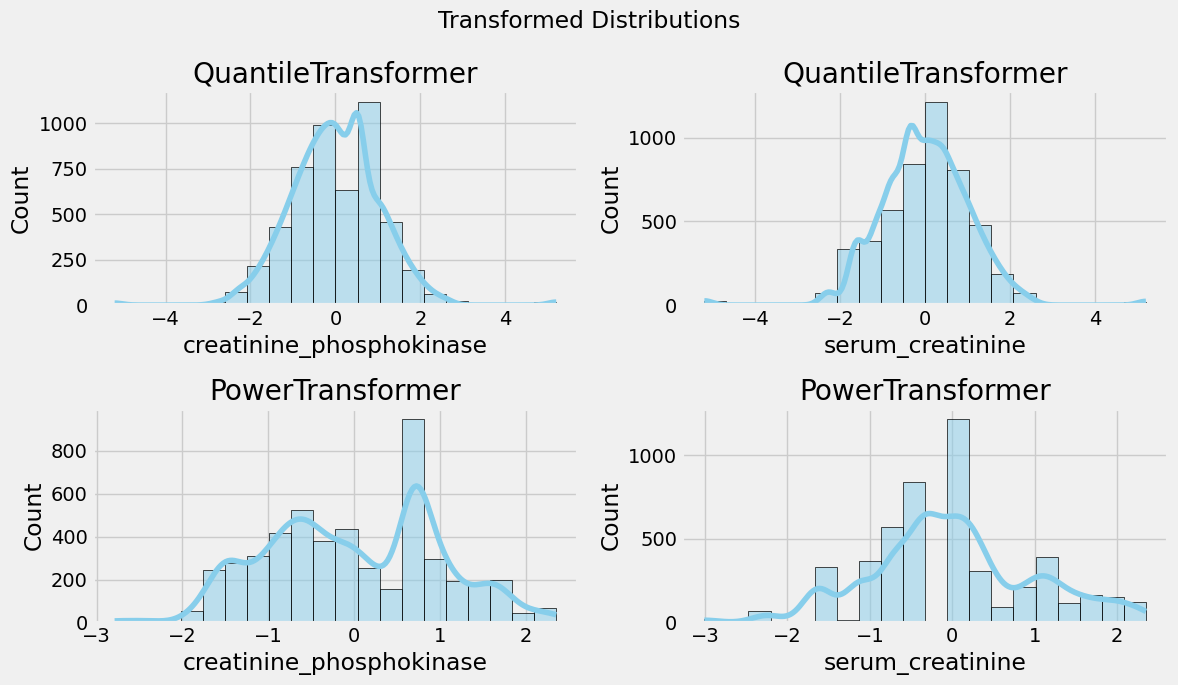

In [199]:
transformers = [
    QuantileTransformer(output_distribution='normal', random_state=0),
    PowerTransformer(standardize=True)
]

fig,axs = plt.subplots(2,2,figsize=(12,7))
fig.suptitle("Transformed Distributions")

for i, t in enumerate(transformers):
  num_cols_transformed = t.fit_transform(df[['creatinine_phosphokinase','serum_creatinine']])
  df_transformed = pd.DataFrame(num_cols_transformed,columns=['creatinine_phosphokinase','serum_creatinine'])

  sns.histplot(x = df_transformed['creatinine_phosphokinase'],ax=axs[i,0],kde=True,bins=20, color = 'skyblue',edgecolor = 'black')
  axs[i,0].set_xlabel('creatinine_phosphokinase')
  axs[i,0].set_title(type(t).__name__)

  sns.histplot(x = df_transformed['serum_creatinine'],ax=axs[i,1],kde=True,bins=20, color = 'skyblue',edgecolor = 'black')
  axs[i,1].set_xlabel('serum_creatinine')
  axs[i,1].set_title(type(t).__name__)

plt.tight_layout()
plt.show()


**Insight**
* Quantile transformation has done good job in removing outliers

In [200]:
# # Seperate independent and dependent variable

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

print(X.shape)
print(y.shape)

(5000, 12)
(5000,)


In [201]:
# train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3750, 12)
(1250, 12)
(3750,)
(1250,)


In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [203]:
lr = LogisticRegression(random_state=42)
cvs = cross_val_score(lr,X_train,y_train,cv=10,n_jobs=-1,scoring='accuracy')
print('Accuracy score cross validation = ',np.mean(cvs))


Accuracy score cross validation =  0.8341333333333333


In [204]:
# Define preprocessor using columnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('quantile', QuantileTransformer(output_distribution='normal'), ['creatinine_phosphokinase','serum_creatinine']),
    ],
    remainder='passthrough'
)

df_pipeline = pd.DataFrame(X_train,columns=df.columns[:-1])
df_pipeline['DEATH_EVENT'] = y_train


pipeline_lr = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
        ('classifier',LogisticRegression())
    ]
)

pipeline_lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('quantile',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['creatinine_phosphokinase',
                                                   'serum_creatinine'])])),
                ('classifier', LogisticRegression())])

In [205]:
# let's observe training results
from sklearn.metrics import accuracy_score, classification_report

x_train_pred = pipeline_lr.predict(X_train)
print('Classification Report Training Data\n\n', classification_report(y_train,x_train_pred))


Classification Report Training Data

               precision    recall  f1-score   support

           0       0.85      0.94      0.89      2551
           1       0.83      0.64      0.72      1199

    accuracy                           0.84      3750
   macro avg       0.84      0.79      0.81      3750
weighted avg       0.84      0.84      0.84      3750



In [206]:
df1 = pd.read_csv('/content/heart_failure_clinical_records.csv')

In [207]:
# scaling with standard scaler

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

from sklearn.preprocessing import StandardScaler

# Standard scaling the numerical features
scaler = StandardScaler()
df1[numerical_features] = scaler.fit_transform(df1[numerical_features])

# Identifying rows where any feature has a z-score < -3 or > 3
mask = (df1[numerical_features] < -3) | (df1[numerical_features] > 3)
rows_to_drop = mask.any(axis=1)

# Dropping the rows
df1_cleaned = df1[~rows_to_drop]

# Display the cleaned DataFrame
df1_cleaned.head()
print(df1_cleaned.shape)

(4697, 13)


In [208]:
df1_cleaned.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,-0.452181,0,0.165097,0,0.631022,0,-0.017526,-0.068446,0.042968,1,1,-0.551989,0
2,-1.307168,0,-0.004874,1,0.023051,0,0.550307,-0.464623,0.715043,0,0,1.465647,0
3,-0.024687,1,0.171240,1,0.196757,1,0.642154,-0.167490,-2.421306,1,0,-0.526122,0
4,2.967771,1,-0.004874,0,-0.671773,0,1.999435,0.624865,-1.077157,1,0,-1.043465,1
5,0.830301,0,-0.363247,1,-0.671773,0,0.376820,-0.167490,-1.077157,1,0,1.025906,0


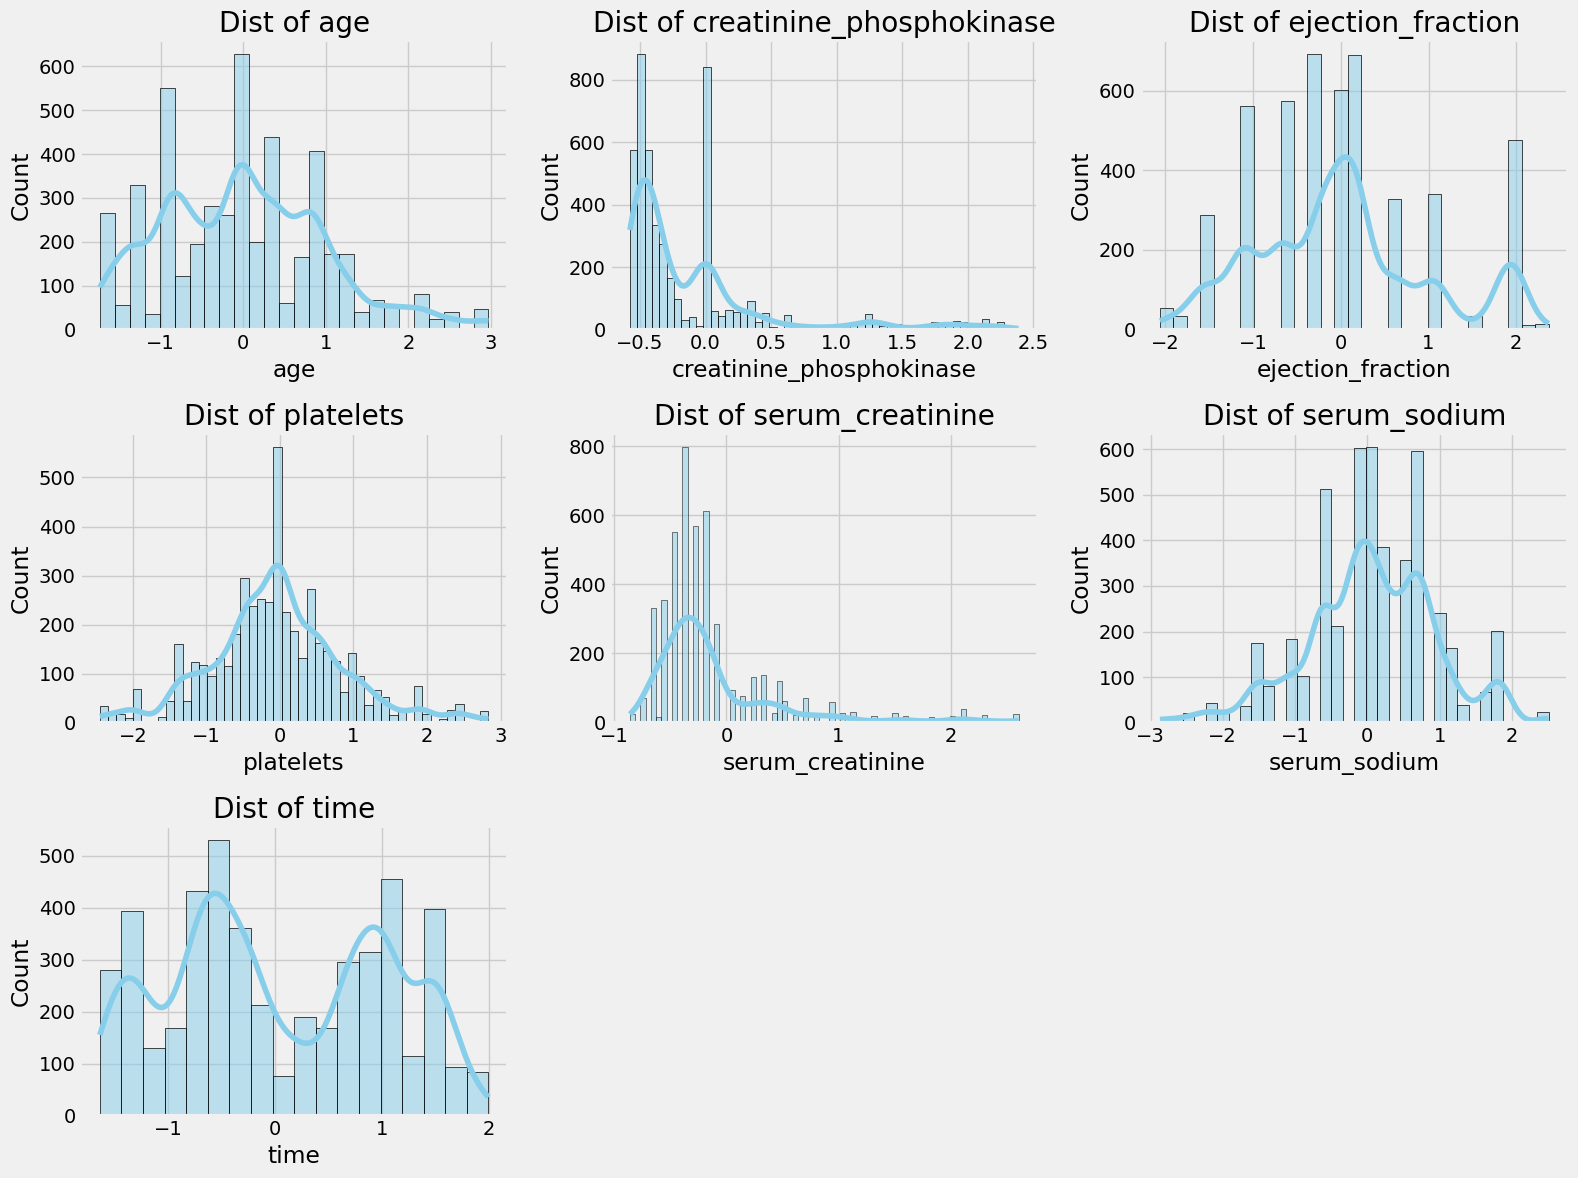

In [209]:
# let's observe distributions of numerical features

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(3,3,figsize=(16,12))

# converts multidimension array into single dimension
axs = np.ravel(axs)

for index, value in enumerate(numerical_features):
  sns.histplot(data=df1_cleaned,x=value,ax=axs[index],kde=True,color = 'skyblue',edgecolor = 'black')
  axs[index].set_title(f'Dist of {value}')

axs[7].set_visible(False)  # Hide subplot 8
axs[8].set_visible(False)  # Hide subplot 9
plt.tight_layout()
plt.show()

In [210]:
# Identifying rows where any feature has a z-score < -3 or > 3
mask = (df1_cleaned[['creatinine_phosphokinase','serum_creatinine']] > 1)
rows_to_drop = mask.any(axis=1)

# Dropping the rows
df1_cleaned = df1_cleaned[~rows_to_drop]

# Display the cleaned DataFrame
df1_cleaned.head()
print(df1_cleaned.shape)

(4115, 13)


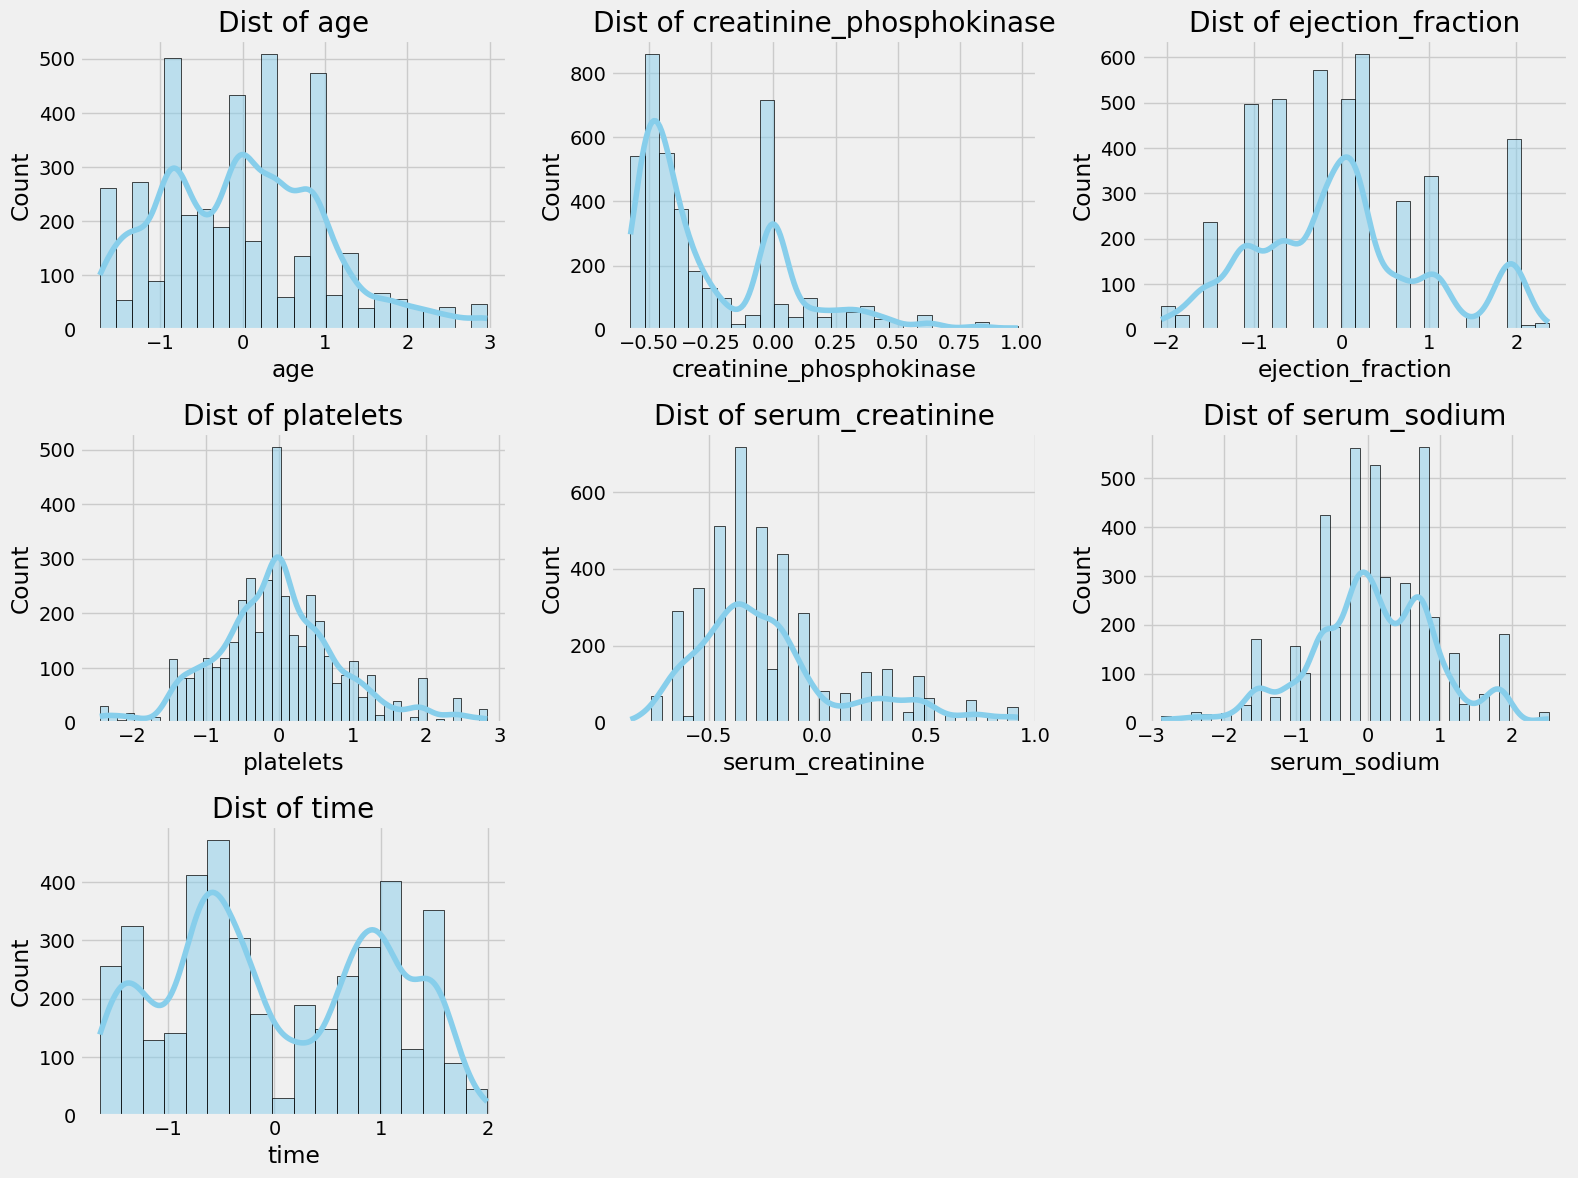

In [211]:
# let's observe distributions of numerical features

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(3,3,figsize=(16,12))

# converts multidimension array into single dimension
axs = np.ravel(axs)

for index, value in enumerate(numerical_features):
  sns.histplot(data=df1_cleaned,x=value,ax=axs[index],kde=True,color = 'skyblue',edgecolor = 'black')
  axs[index].set_title(f'Dist of {value}')

axs[7].set_visible(False)  # Hide subplot 8
axs[8].set_visible(False)  # Hide subplot 9
plt.tight_layout()
plt.show()

In [212]:
# # Seperate independent and dependent variable

X = df1_cleaned.iloc[:,:-1]
y = df1_cleaned.iloc[:,-1]

print(X.shape)
print(y.shape)

(4115, 12)
(4115,)


In [213]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [217]:
lr2 = LogisticRegression(random_state=42)
cvs = cross_val_score(lr,X_train,y_train,cv=10,n_jobs=-1,scoring='accuracy')
print('Accuracy score cross validation = ',np.mean(cvs))

Accuracy score cross validation =  0.8593819610809902


**Insight**
* By removing outliers, we were able to improve model performace slightly from 0.83 to 0.85

In [215]:
x_train_pred = lr2.predict(X_train)

In [216]:
print('Classification Report\n\n',classification_report(y_train,x_train_pred))

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2239
           1       0.77      0.72      0.74       847

    accuracy                           0.86      3086
   macro avg       0.83      0.82      0.82      3086
weighted avg       0.86      0.86      0.86      3086



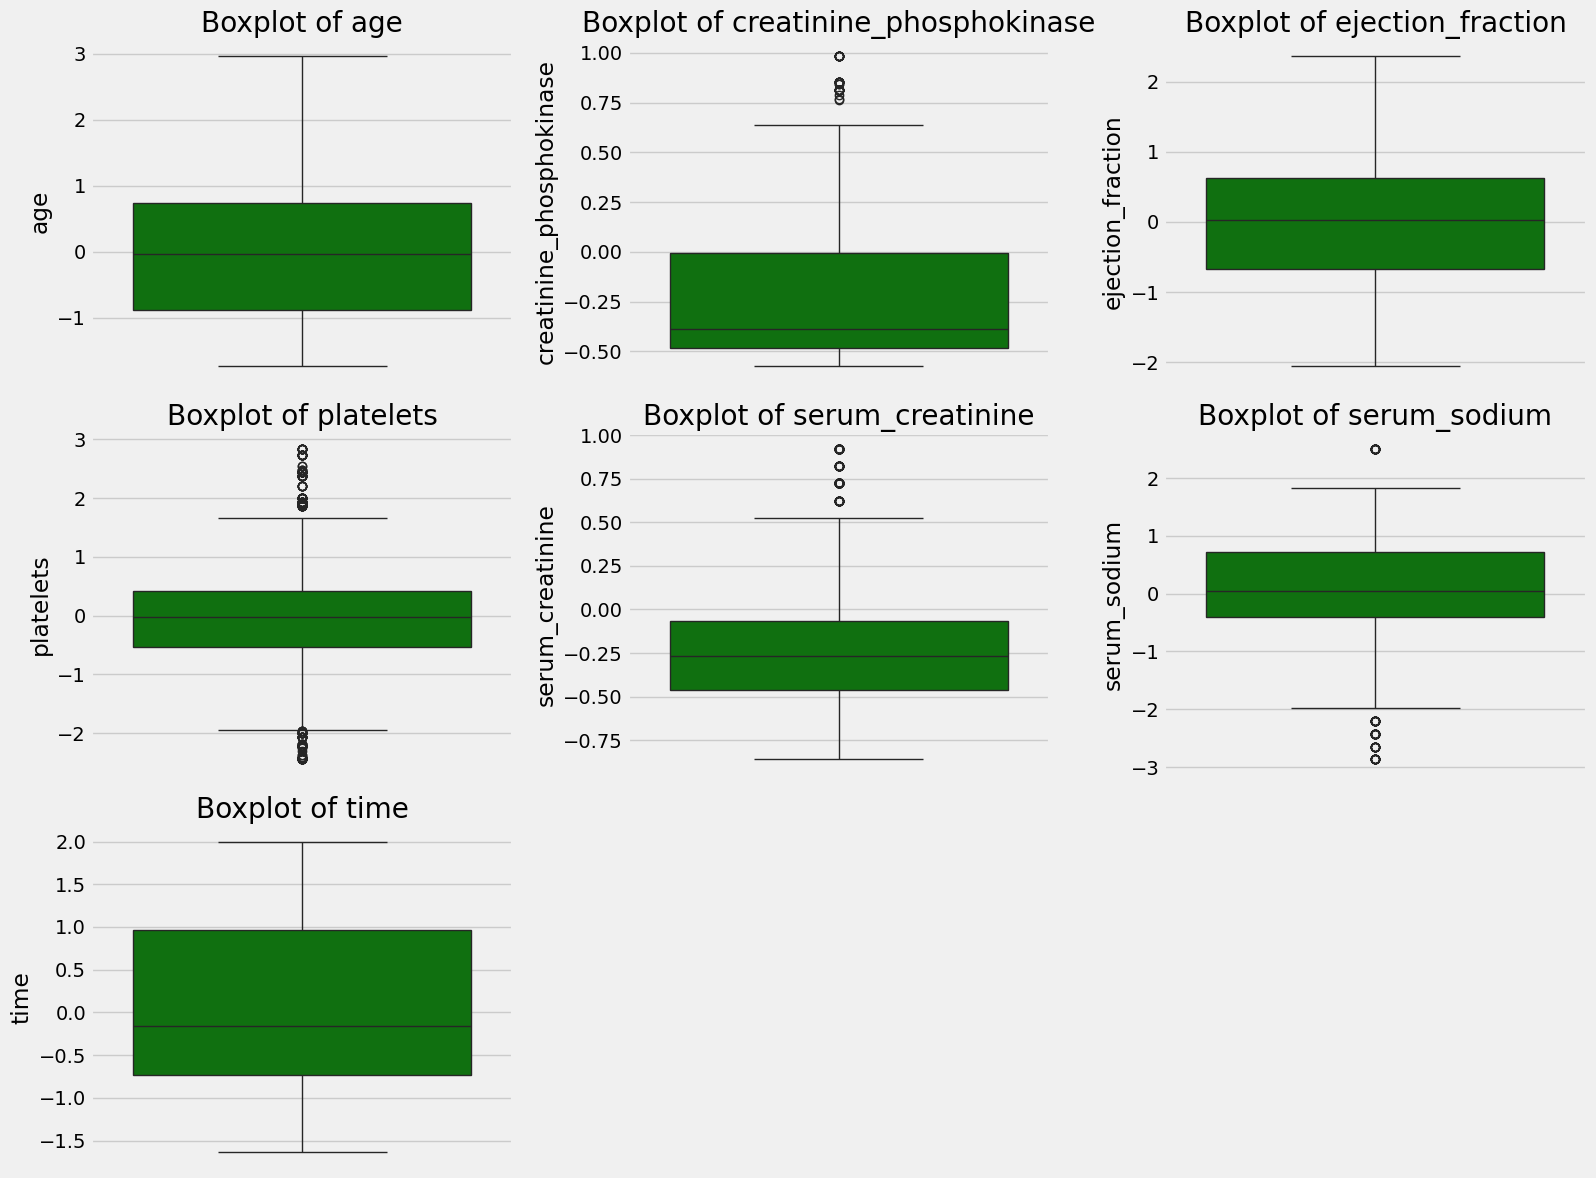

In [218]:
# Outliers in numerical columns

numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(3,3,figsize=(16,12))

# converts multidimension array into single dimension
axs = np.ravel(axs)

for index, value in enumerate(numerical_features):
  sns.boxplot(data=df1_cleaned,y=value,ax=axs[index],color='green')
  axs[index].set_title(f'Boxplot of {value}')

axs[7].set_visible(False)  # Hide subplot 8
axs[8].set_visible(False)  # Hide subplot 9
plt.tight_layout()
plt.show()